# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [35]:
import pandas as pd
import numpy as np
import spacy
import sys
!{sys.executable} -m pip install spacy

!{sys.executable} -m spacy download en

from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from catboost import Pool, CatBoostClassifier, cv
import csv
import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
!spacy download en_core_web_sm
import re
from tqdm import notebook
notebook.tqdm.pandas() 

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.9 MB 2.1 MB/s eta 0:00:01��███████▍| 13.6 MB 2.1 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     |████████████████████████████████| 13.9 MB 9.3 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [36]:
notebook.tqdm.pandas() 

In [37]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [38]:
df.head(20)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


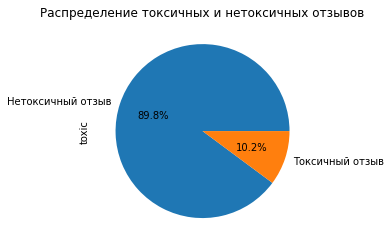

In [40]:
df['toxic'].value_counts().plot(kind='pie', legend=False, autopct='%1.1f%%', labels=['Нетоксичный отзыв', 'Токсичный отзыв'])
plt.title('Распределение токсичных и нетоксичных отзывов')
plt.show()

Токсичных отзывов около 10%

Токенизируем и лемминизирует данные.

In [43]:
%%time
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lemmatize(sentence):
    sentence = sentence.lower()
#    nlp = spacy.load('en_core_web_sm')
    doc = nlp(sentence)
    lemmatized_output = ' '.join([token.lemma_ for token in doc])
    final_text = re.sub(r'[^a-zA-Z]', ' ', lemmatized_output)
    return ' '.join(final_text.split())


CPU times: user 510 ms, sys: 31.7 ms, total: 542 ms
Wall time: 563 ms


In [ ]:
%%time
df['lemm_text'] = df['text'].progress_apply(lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

При этом типе лемматизации, сама лемматизация проходит достаточно долго, зато модели обучаются быстрее. В общем и целом Spacy быстрее

In [ ]:
#%%time
#lemmatizer = WordNetLemmatizer()

#def lemmatize_text(text):
#    text = text.lower()
#    lemm_text = "".join(lemmatizer.lemmatize(text))
#    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
#    return " ".join(cleared_text.split())

#df['lemm_text'] = df['text'].progress_apply(lemmatize_text)

При данном типе лемматизации, она проходит моментально, однако модели обучаются очень долго

In [ ]:
df

In [ ]:
features = df['lemm_text']
target = df['toxic']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)

In [ ]:
features_train.shape

In [ ]:
features_test.shape

In [ ]:
target_train.shape

In [ ]:
target_test.shape

Все данные на месте

Создадим список стоп слов

In [ ]:
stopwords = set(nltk_stopwords.words('english'))
stopwords

In [ ]:
tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf_train = tf_idf.fit_transform(features_train)
tf_idf_test = tf_idf.transform(features_test)

## Обучение

Найдем оптимальную модель с помощью кросс валидации.

In [ ]:
%%time
model = LogisticRegression(max_iter=600, random_state=12345, class_weight='balanced')
mean_scores = cross_val_score(model, tf_idf_train, target_train, cv=5, scoring='f1').mean()
mean_scores

In [ ]:
model = DecisionTreeClassifier(random_state=12345, class_weight = 'balanced')
mean_scores = cross_val_score(model, tf_idf_train, target_train, cv=5, scoring='f1').mean()
mean_scores

In [ ]:
%%time
model_catboost = CatBoostClassifier(iterations=600, learning_rate=0.5, verbose=100, random_state=12345)
mean_scores = cross_val_score(model_catboost, tf_idf_train, target_train, cv=2, scoring='f1').mean()
mean_scores

Оптимальную модель с лучшими гиперпараметрами мы нашли, теперь протестируем ее

In [ ]:
%%time
model = CatBoostClassifier(iterations=600, learning_rate=0.5, verbose=100, random_state=12345)
model.fit(tf_idf_train, target_train)
predictions = model.predict(tf_idf_test)
    
test_f1 = f1_score(target_test, predictions)
test_f1

Тестирование показало метрику f1 более 0.75

## Выводы

В результате исследования были проанализированы данные о токсичности комментариев. Оказалось, что токсичных комментариев, около 10%. Комментарии были токенизированы и лемминизированы. Далее был создан список стоп слов, а данные векторизированны. В ходе обучения моделей и последующей проверки их на метрике f1 обнаружена оптимальная модель с гиперпараметрами: CatBoostClassifier(iterations=600, learning_rate=0.5, verbose=100, random_state=12345). Найденная модеь сможет эффективно находить токсичные комментарии.